In [2]:
import pandas as pd
import numpy as np
import json
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
#Load tree and sequence files
with open('../auspice/flu_seasonal_h3n2_ha_6y_tree.json', 'r') as jsonfile:
    tree_6y = json.load(jsonfile)

with open('../auspice/flu_seasonal_h3n2_ha_6y_sequences.json', 'r') as jsonfile:
    seq_6y = json.load(jsonfile)

#Load genbank file with reference HA sequence
ref_names = {'hemagglutinin':'hemagglutinin','Signal peptide':'SP_ref','HA1 protein':'HA1_ref', 'HA2 protein':'HA2_ref'}
ref_seqs = {}

for seq_record in SeqIO.parse('../h3n2_outgroup.gb', 'genbank'):
    for feature in seq_record.features:
        if feature.type=='CDS':
            ref_seqs[str(ref_names[feature.qualifiers['product'][0]])]= (feature.location.extract(seq_record).seq.translate())

/anaconda2/lib/python2.7/site-packages/Bio/Seq.py:2309: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [20]:
#Input desired 0-based HA1 amino acid residue positions, find reference amino acid

positions = [160,194,186,225,219,203,156,138]
position_refaa = []

for pos in positions:
    position_refaa.append((str(pos-1), ref_seqs['HA1_ref'][pos-1]))
    
    
tip_muts = {}

def traverse(branch, seq, pos_list):

    if 'children' not in branch.keys():

        tip_muts[branch['strain']]=[branch['aa_muts']['HA1'], branch['aa_muts']['HA2'], 
                                    branch['aa_muts']['SigPep'],branch['attr']['num_date'], 
                                    branch['attr']['clade_membership']] + [str(seq[str(branch['clade'])]['HA1'][pos]) if pos in seq[str(branch['clade'])]['HA1'] else str(ref_aa) 
                                    for pos, ref_aa in pos_list]

    else:
        for child in branch['children']:
            traverse(child, seq, pos_list)

    
traverse(tree_6y, seq_6y, position_refaa)

#Organize data in a DF
df = pd.DataFrame(tip_muts).T
df.reset_index(inplace=True)
df.columns = ['strain', 'tip_HA1_muts', 'tip_HA2_muts', 'tip_SigPep_muts', 'date', 'clade']+positions
df['passage'] = np.select((df.strain.str.contains('egg'), df.strain.str.contains('cell')), ('egg', 'cell'))
df['source'] = np.select((df.passage=='egg', df.passage=='cell', df.passage=='0'), 
                         (df.strain.str.replace('-egg',''), df.strain.str.replace('-cell',''), df.strain))

#!!!! Must first check all sites of insterest to make sure clades have predeominantly one genotype!!!!
#At each position, find predominant genotype of circulating virus by clade
#Use this to determine whether egg-passaged strains have mutated
#!!!! Must first check all sites of insterest to make sure clades have predeominantly one genotype!!!!

clade_gtype = {}
for p in positions:
    clade_gtype_pos = {}
    for c_name, clade in df[df['passage']=='0'].groupby('clade'):
        clade_gtype_pos[c_name] = str(clade[p].value_counts().nlargest(1))[0]
    clade_gtype[p] = clade_gtype_pos

for p in positions:
    df['circulating'+str(p)] = df['clade'].map(clade_gtype[p])

#make tidy version of df where each mutation gets a row
mut_df = pd.DataFrame(columns=['mutation']+ list(df.columns))

count=0
for i, r in df.iterrows():

    for ha1_mut in r['tip_HA1_muts']:
        mut_df.loc[count]= ['HA1'+str(ha1_mut)] + list(df.loc[i])
        count+=1
        
    for ha2_mut in r['tip_HA2_muts']:
        mut_df.loc[count]= ['HA2'+str(ha2_mut)] + list(df.loc[i])
        count+=1
        
    for sp_mut in r['tip_SigPep_muts']:
        mut_df.loc[count]= ['SP'+str(sp_mut)] + list(df.loc[i])
        count+=1

In [21]:
#Determine whether there sequence has mutated relative to clade background, at each position
for p in positions:
    
    df['mut'+str(p)] = np.select(
    (df[p]==df['circulating'+str(p)], df[p]!=df['circulating'+str(p)]), 
    (False, True))

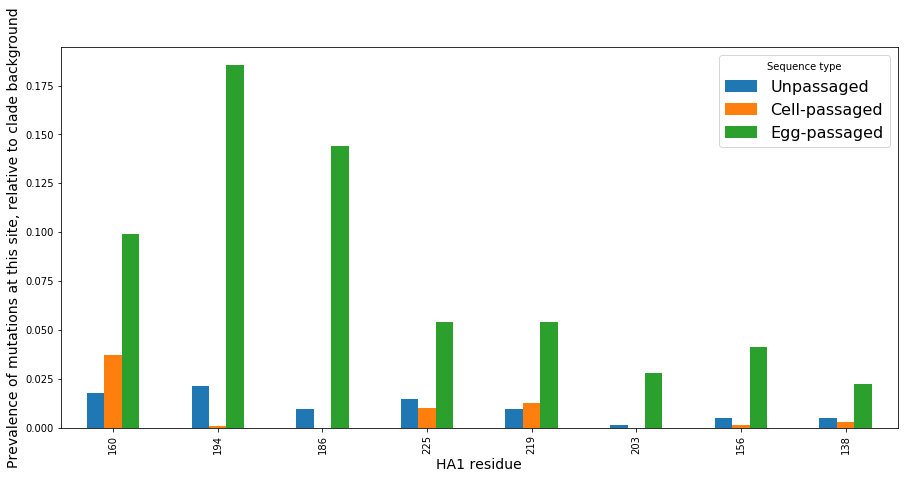

In [106]:
#Make DF with portion of sequences that are mutated compared to clade background, at each site, bt passage type
mut_prev_df = pd.DataFrame()
for p in positions:
    mut_prev= df.groupby('passage')['mut'+str(p)].value_counts(normalize=True)
    mut_prev.name= 'mut_prev'+str(p)
    mut_prev = mut_prev.reset_index().set_index('passage')
    mut_prev_df[p] = mut_prev[mut_prev['mut'+str(p)]==1]['mut_prev'+str(p)]

fig, ax = plt.subplots(figsize=(15,7))
fig = mut_prev_df.T.plot(kind='bar', ax=ax)
plt.xlabel('HA1 residue', size=14)
plt.ylabel('Prevalence of mutations at this site, relative to clade background', size=14)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Unpassaged", "Cell-passaged", "Egg-passaged"], title='Sequence type', loc=1, fontsize=16)